In [3]:
import SDR
import statsmodels.api as sm
import pandas as pd
import numpy as np
import scipy as sp
import copy
import imp
import DynamicRegression as DR

# Seasonal Dynamic Regression (SDR) class demo

Simulate a UC model for the time varying regression coefficients

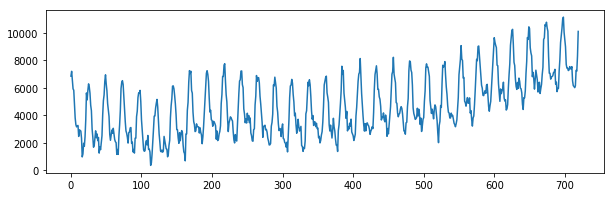

In [129]:
n_points=24*30
np.random.seed(12345)
mod = sm.tsa.UnobservedComponents(np.zeros(n_points),"local level",
            freq_seasonal=[{"period":24,"harmonics":2}])
coefs = mod.simulate(params=(100000,10000,10),nsimulations=n_points)+3000
pd.Series(coefs).plot(figsize=(10,3))

Generate the exogenous covariates as a sequence of exponentially distributed random variables. The endogenous data is given by multiplying the exogenous covariates by the simulated regression coefficients and adding some noise white.

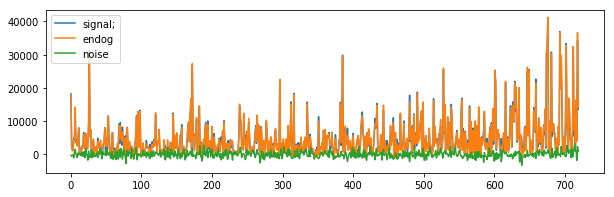

In [130]:
np.random.seed(12345)
exog = np.random.exponential(1,n_points)
noise = np.random.normal(scale=np.var(exog)*1000,size=n_points)
signal = exog*coefs
endog = signal + noise
pd.DataFrame({"signal;":signal,"endog":endog,"noise":noise}).plot(figsize=(10,3))


The SDR class implements the model:


$y_t = \beta_t x_t + \epsilon_t$

$\beta_t = \mu_t + \gamma_t$

$\mu_t = \mu_{t-1} + \eta_t$


$\gamma_{t} = \sum\limits_{j=1}^{[s/2]} \gamma_{j,t}$

where:

$\gamma_{j,t+1} = \gamma_{j,t} \textrm{cos}(\lambda_j) + \gamma_{j,t}^\ast \textrm{sin}(\lambda_j) + \omega_{j,t}$

$\gamma_{j,t+1}^\ast = - \gamma_{j,t} \textrm{sin}(\lambda_j) + \gamma_{j,t}^\ast \textrm{cos}(\lambda_j) + \omega_{j,t}$

$\lambda_j = \frac{2\pi j}{s}$ for $j = 1,..., [s/2]$

and   $\epsilon_t \sim N(0,\sigma_{\epsilon}^2)$, $\eta_{t} \sim N(0,\sigma_{\eta}^2)$ and $\omega_{j,t} \sim N(0,\sigma_{\omega}^2)$

In [131]:
nharmonics=2
freq_seasonal=[{"period":24,"harmonics":nharmonics}]
sdr=SDR.SDR(endog,exog,freq_seasonal,level=False,exog_errors=False)
results = sdr.fit()

Plot the data compared to the fitted values and the regression coefficients decomposed into level and seasonal components

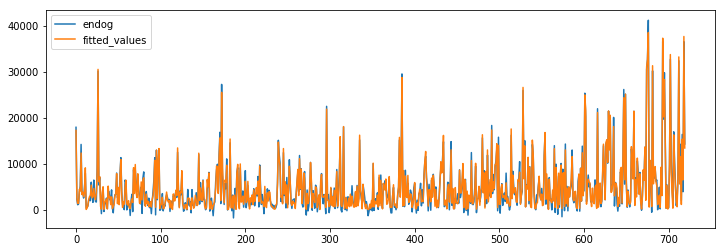

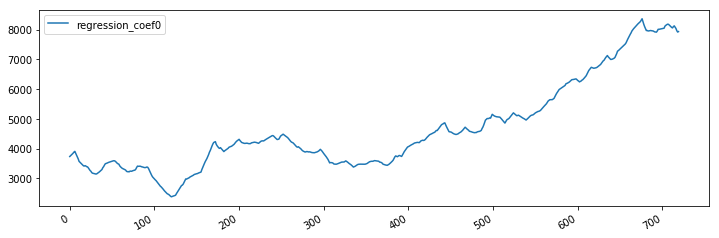

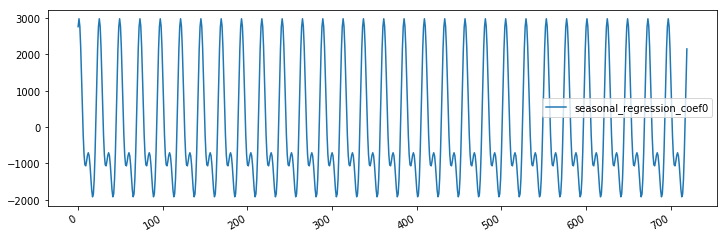

In [132]:
SDR.plot(results,which="smoothed",figsize=(12,4),combine=False)

In [134]:
imp.reload(DR)
mod = sm.tsa.UnobservedComponents(np.zeros(n_points),"local level",
            freq_seasonal=[{"period":24,"harmonics":2}])

dr = DR.SARIMAX(endog,exog,exog_models=mod)
dr.fit()

RuntimeError: Initialization is incomplete.